# Sarcasm Detection RNN
In this notebook, we'll implement a recurrent neural network that performs sarcasm detection. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import dill

In [93]:
data = pd.read_csv('../data/train_data_clean.csv')
reviews = list(data['tweet'].apply(str))
labels = list(data['label'])

In [94]:
print(reviews[:10])
print()
print(labels[:10])

[' NAME I urge all charity working for to help translate khanacademy into local languages & amp make it available offline', ' NAME Wonder how your members of Congress voted on key legislation  Check it out by putting in your zip code htt…', ' The Electric Company Party Game Lost on Prankster Planet iOSApp/iOSAp by PBSKIDS HYPERLINK', ' Ethics Where do morals come from  via Philip Gorski NAME HYPERLINK writing politics', ' Star Rover HD Stargazing and Night Sky Watching Education  HYPERLINK ipad Reference', ' Lessons versus Learning by NAME on NAME HYPERLINK administration bullying schoolviolence', " Here's a great channel to watch to help you getyourhealthyon HYPERLINK", " familyplanning access to economic resources are all women's rights but still a dream in many countries HYPERLINK", ' NAME Scholarships for young leaders who aspire to make a difference in the world HYPERLINK scholarship edu…', ' Mastering a new language can completely rewire your brain says studyHYPERLINK HYPERLINK']

In [95]:
corpus = [word for sent in reviews for word in sent.split()]

In [96]:
len(corpus)

51692

In [97]:
from collections import Counter

## Build a dictionary 
counts = Counter(corpus)
vocab = sorted(counts, key=counts.get, reverse=True)
vocab_to_int = {word: ii for ii, word in enumerate(vocab, 1)}

In [98]:
reviews_ints = []
for review in reviews:
    reviews_ints.append([vocab_to_int[word] for word in review.split()])

In [99]:
reviews_ints[:1]

[[1,
  7,
  1457,
  28,
  724,
  237,
  9,
  4,
  123,
  1458,
  2662,
  160,
  725,
  486,
  17,
  24,
  97,
  15,
  524,
  1905]]

In [100]:
review_lens = Counter([len(x) for x in reviews_ints])
print("Maximum review length: {}".format(max(review_lens)))

Maximum review length: 31


Text(0, 0.5, 'Count')

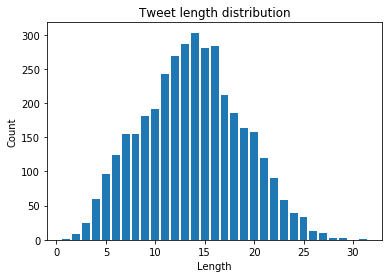

In [101]:
plt.bar(review_lens.keys(), review_lens.values())
plt.title("Tweet length distribution")
plt.xlabel("Length")
plt.ylabel("Count")


In [102]:
def pad_features(reviews_ints, seq_length):
    ''' Return features of review_ints, where each review is padded with 0's 
        or truncated to the input seq_length.
    '''
    
    # getting the correct rows x cols shape
    features = np.zeros((len(reviews_ints), seq_length), dtype=int)

    # for each review, I grab that review and 
    for i, row in enumerate(reviews_ints):
        features[i, -len(row):] = np.array(row)[:seq_length]
    
    return features

In [103]:
# Test your implementation!

seq_length = 20

features = pad_features(reviews_ints, seq_length=seq_length)

## test statements - do not change - ##
assert len(features)==len(reviews_ints), "Your features should have as many rows as reviews."
assert len(features[0])==seq_length, "Each feature row should contain seq_length values."

# print first 10 values of the first 30 batches 
print(features[1])

[   1 1906   45   31 1907    6 1178 1908   13  525 4677  293   15   33
   34 1179    8   31 4678 2663]


In [104]:
split_frac = 0.80

## split data into training, validation, and test data (features and labels, x and y)

split_idx = int(len(features)*split_frac)
train_x, remaining_x = features[:split_idx+1], features[split_idx-1:]
train_y, remaining_y = labels[:split_idx+1], labels[split_idx-1:]

print(len(remaining_x))
test_idx = int((len(remaining_x)-4)*0.5)
val_x, test_x = remaining_x[:test_idx], remaining_x[test_idx+4:]
val_y, test_y = remaining_y[:test_idx], remaining_y[test_idx+4:]

## print out the shapes of your resultant feature data
print("\t\t\tFeature Shapes:")
print("Train set: \t\t{}".format(train_x.shape), 
      "\nValidation set: \t{}".format(val_x.shape),
      "\nTest set: \t\t{}".format(test_x.shape))

752
			Feature Shapes:
Train set: 		(3004, 20) 
Validation set: 	(374, 20) 
Test set: 		(374, 20)


In [105]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(np.asarray(train_x)), torch.from_numpy(np.asarray(train_y)))
valid_data = TensorDataset(torch.from_numpy(np.asarray(val_x)), torch.from_numpy(np.asarray(val_y)))
test_data = TensorDataset(torch.from_numpy(np.asarray(test_x)), torch.from_numpy(np.asarray(test_y)))

# dataloaders
batch_size = 32

# make sure the SHUFFLE your training data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

In [106]:
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print()
print('Sample label size: ', sample_y.size()) # batch_size
print('Sample label: \n', sample_y)

Sample input size:  torch.Size([32, 20])
Sample input: 
 tensor([[   0,    0,    0,    0,    1, 1542,   11,  353, 2818,   21,    8,   20,
         1543, 1994,   28, 2819,  228,    2, 2820,    2],
        [   0,    0,    0,    0,    0,    0,    0,    0,    1, 1600,  618, 1285,
         1623,   56,  243,  215,  141,    2,  324,  243],
        [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0, 1068, 1869,
            4,   20,  619,   79, 8469, 2530, 8470,    2],
        [   0,    0,    0,    0,    0,    0,    1,  111,    1,  836, 6186, 1310,
            6,  468, 2184, 6187,    2,   61,    1,    2],
        [   0,    0,  270,    4,   58,   18,  262,    6,    3, 2035,  198,  176,
            8, 1239,  227,  363,    9,  835,    2,  760],
        [ 130,   23,    4,  476, 1822,  821,   14,    8,  208,  677, 7878,   23,
            5,  464,    4,   66,  161,  112,   21, 7879],
        [   0,    0,    0,    0,    0,    0,    0,    1, 2056, 2927,  206, 1584,
           67,  869,   56, 2

In [107]:
# First checking if GPU is available
train_on_gpu=torch.cuda.is_available()

if(train_on_gpu):
    print('Training on GPU.')
else:
    print('No GPU available, training on CPU.')

No GPU available, training on CPU.


In [108]:
import torch.nn as nn

class SentimentRNN(nn.Module):
    """
    The RNN model that will be used to perform Sentiment analysis.
    """

    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        """
        Initialize the model by setting up the layers.
        """
        super(SentimentRNN, self).__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, 
                            dropout=drop_prob, batch_first=True)
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)
        
        # linear and sigmoid layers
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sig = nn.Sigmoid()
        

    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)

        # embeddings and lstm_out
        x = x.long()
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
    
        # stack up lstm outputs
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        # dropout and fully-connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        # sigmoid function
        sig_out = self.sig(out)
        
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1] # get last batch of labels
        
        # return last sigmoid output and hidden state
        return sig_out, hidden
    
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        
        return hidden
        

In [109]:
# Instantiate the model w/ hyperparams
vocab_size = len(vocab_to_int)+1 # +1 for the 0 padding + our word tokens
output_size = 1
embedding_dim = 512
hidden_dim = 100
n_layers = 2

net = SentimentRNN(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)

print(net)

SentimentRNN(
  (embedding): Embedding(11138, 512)
  (lstm): LSTM(512, 100, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=100, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [110]:
# loss and optimization functions
lr=0.001

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)


In [111]:
# training params

epochs = 2 # 3-4 is approx where I noticed the validation loss stop decreasing

counter = 0
print_every = 10
clip=5 # gradient clipping

# move model to GPU, if available
if(train_on_gpu):
    net.cuda()

net.train()
# train for some number of epochs
for e in range(epochs):
    # initialize hidden state
    h = net.init_hidden(batch_size)

    # batch loop
    for ii, (inputs, labels) in enumerate(train_loader):
        if 3004//batch_size > ii:
            counter += 1

            if(train_on_gpu):
                inputs, labels = inputs.cuda(), labels.cuda()

            # Creating new variables for the hidden state, otherwise
            # we'd backprop through the entire training history
            h = tuple([each.data for each in h])

            # zero accumulated gradients
            net.zero_grad()

            # get the output from the model
            output, h = net(inputs, h)

            # calculate the loss and perform backprop
            loss = criterion(output.squeeze(), labels.float())
            loss.backward()
            # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            nn.utils.clip_grad_norm_(net.parameters(), clip)
            optimizer.step()

            # loss stats
            if counter % print_every == 0:
                # Get validation loss
                val_h = net.init_hidden(batch_size)
                val_losses = []
                net.eval()
                for jj, (inputs, labels) in enumerate(valid_loader):
                    
                    if 374//batch_size > jj:
                        # Creating new variables for the hidden state, otherwise
                        # we'd backprop through the entire training history
                        val_h = tuple([each.data for each in val_h])

                        if(train_on_gpu):
                            inputs, labels = inputs.cuda(), labels.cuda()
        #                 print(inputs.shape)
        #                 print(labels.shape)

                        output, val_h = net(inputs, val_h)
                        val_loss = criterion(output.squeeze(), labels.float())

                        val_losses.append(val_loss.item())

                net.train()
                print("Epoch: {}/{}...".format(e+1, epochs),
                      "Step: {}...".format(counter),
                      "Loss: {:.6f}...".format(loss.item()),
                      "Val Loss: {:.6f}".format(np.mean(val_losses)))

Epoch: 1/2... Step: 10... Loss: 0.660176... Val Loss: 0.707615
Epoch: 1/2... Step: 20... Loss: 0.573454... Val Loss: 0.558197
Epoch: 1/2... Step: 30... Loss: 0.490775... Val Loss: 0.391767
Epoch: 1/2... Step: 40... Loss: 0.322353... Val Loss: 0.318318
Epoch: 1/2... Step: 50... Loss: 0.408423... Val Loss: 0.382278
Epoch: 1/2... Step: 60... Loss: 0.652151... Val Loss: 0.372609
Epoch: 1/2... Step: 70... Loss: 0.392112... Val Loss: 0.196500
Epoch: 1/2... Step: 80... Loss: 0.234036... Val Loss: 0.347960
Epoch: 1/2... Step: 90... Loss: 0.304958... Val Loss: 0.205577
Epoch: 2/2... Step: 100... Loss: 0.132183... Val Loss: 0.164994
Epoch: 2/2... Step: 110... Loss: 0.192994... Val Loss: 0.161079
Epoch: 2/2... Step: 120... Loss: 0.462370... Val Loss: 0.244294
Epoch: 2/2... Step: 130... Loss: 0.369860... Val Loss: 0.225495
Epoch: 2/2... Step: 140... Loss: 0.069687... Val Loss: 0.194486
Epoch: 2/2... Step: 150... Loss: 0.037168... Val Loss: 0.154717
Epoch: 2/2... Step: 160... Loss: 0.155006... Val 

In [112]:
# Get test data loss and accuracy

test_losses = [] # track loss
num_correct = 0

# init hidden state
h = net.init_hidden(batch_size)

net.eval()
# iterate over test data
for jj, (inputs, labels) in enumerate(test_loader):
    if 374//batch_size > jj:
    
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])

        if(train_on_gpu):
            inputs, labels = inputs.cuda(), labels.cuda()

        # get predicted outputs
        output, h = net(inputs, h)

        # calculate loss
        test_loss = criterion(output.squeeze(), labels.float())
        test_losses.append(test_loss.item())

        # convert output probabilities to predicted class (0 or 1)
        pred = torch.round(output.squeeze())  # rounds to the nearest integer

        # compare predictions to true label
        correct_tensor = pred.eq(labels.float().view_as(pred))
        correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
        num_correct += np.sum(correct)


# -- stats! -- ##
# avg test loss
print("Test loss: {:.3f}".format(np.mean(test_losses)))

# accuracy over all test data
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.3f}".format(test_acc))

Test loss: 0.222
Test accuracy: 0.864


In [162]:
torch.save(net.state_dict(), 'model.brain')

In [166]:
with open('vocab_to_int.dict', 'wb+') as file:
    dill.dump(vocab_to_int, file, dill.HIGHEST_PROTOCOL)